# **Question - Answering System on SQUAD Dataset using HuggingFace T5 with Fine Tuning**

#### **Problem Introduction**

Question-answering systems are essential in natural language processing, providing automated responses to user queries based on a given context. This project focuses on building a QA system using the SQuAD (Stanford Question Answering Dataset) to evaluate and answer questions accurately. Leveraging advanced transformer models like T5 from HuggingFace, the system will be fine-tuned to improve performance and accuracy in extracting relevant answers from the provided context.

#### **About the Dataset**

The SQuAD dataset is a widely used benchmark for training and evaluating QA models. It consists of over 100,000 question-answer pairs, derived from Wikipedia articles. Each entry includes a passage of text (context) and associated questions, with the corresponding answers highlighted within the context. This dataset provides a diverse range of topics and question types, making it an ideal resource for training a robust and generalizable QnA model.

#### **Aim**

The aim of this project is to develop and fine-tune a QnA system using the T5 model from HuggingFace on the SQuAD dataset. The objectives include:

- Preprocessing and tokenizing the dataset to prepare it for model training.
- Fine-tuning the T5 model to enhance its performance in answering questions based on the given contexts.
- Evaluating the model's performance using appropriate metrics to ensure its accuracy and effectiveness in real-world scenarios.
- Demonstrating the practical application of advanced transformer models in QnA systems.

## **Instal Dependencies**

- `transformers`: For working with transformer models.
- `datasets`: For accessing and handling datasets.
- `evaluate`: For evaluating model performance.
- `rouge`: For calculating ROUGE scores in text summarization tasks.

In [ ]:
# Install dependencies
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install rouge

# Clear the output
from IPython.display import clear_output
clear_output()

## **Import Python Libraries**

In [ ]:
# Import python modules
import torch
import json
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
import nltk
import spacy
import string
import evaluate
from torch.utils.data import Dataset, DataLoader, RandomSampler
import pandas as pd
from datasets import load_dataset
import numpy as np
import transformers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## **Load SQUAD Dataset: QnA**

In [ ]:
# Load SQUAD Question-Answering Data: Considering 10000 samples out of 100000 (10% of whole data) for smoother training

squad_data = load_dataset("squad", split="train[:10000]")
squad_data

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 10000
})

In [ ]:
# Show the first sample from the train set
squad_data = squad_data.train_test_split(test_size=0.2)
squad_data

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 2000
    })
})

In [ ]:
# Show the first sample from the train set
squad_data["train"][0]

{'id': '573406cd4776f41900661729',
 'title': 'Portugal',
 'context': 'Travel and tourism continue to be extremely important for Portugal, with visitor numbers forecast to increase significantly in the future.[citation needed] However, the increasing competition from Eastern European destinations continues to develop, with the presence of similar attractions that are often cheaper in countries such as Croatia. Consequently, it has been necessary for the country to focus upon its niche attractions, such as health, nature and rural tourism, to stay ahead of its competitors.',
 'question': 'Portuguese tourist numbers are expected to do what in the future?',
 'answers': {'text': ['increase'], 'answer_start': [101]}}

In [ ]:
# Show the first sample from the test set
squad_data["test"][0]

{'id': '56d630a31c85041400946fc4',
 'title': 'Dog',
 'context': 'Dog meat is consumed in some East Asian countries, including Korea, China, and Vietnam, a practice that dates back to antiquity. It is estimated that 13–16 million dogs are killed and consumed in Asia every year. Other cultures, such as Polynesia and pre-Columbian Mexico, also consumed dog meat in their history. However, Western, South Asian, African, and Middle Eastern cultures, in general, regard consumption of dog meat as taboo. In some places, however, such as in rural areas of Poland, dog fat is believed to have medicinal properties—being good for the lungs for instance. Dog meat is also consumed in some parts of Switzerland. Proponents of eating dog meat have argued that placing a distinction between livestock and dogs is western hypocrisy, and that there is no difference with eating the meat of different animals.',
 'question': 'Where do some people eat dogs?',
 'answers': {'text': ['East Asian countries'], 'answer

### Create Pandas Dataframe


- **`train_data = pd.DataFrame(squad_data['train'])`**: Converts the training data from the `squad_data` dictionary into a Pandas DataFrame. This DataFrame (`train_data`) will be used for further data manipulation and processing.
  
- **`test_data = pd.DataFrame(squad_data['test'])`**: Similarly, this converts the test data from the `squad_data` dictionary into a Pandas DataFrame (`test_data`).




In [ ]:
# Create a Dataframe

train_data = pd.DataFrame(squad_data['train'])
test_data = pd.DataFrame(squad_data['test'])

In [ ]:
# Shape of both dataframes

train_data.shape, test_data.shape

((8000, 5), (2000, 5))

In [ ]:
# Top 3 samples from the train set
train_data.head(3)

,id,title,context,question,answers
0,573406cd4776f41900661729,Portugal,Travel and tourism continue to be extremely im...,Portuguese tourist numbers are expected to do ...,"{'text': ['increase'], 'answer_start': [101]}"
1,56d9670fdc89441400fdb3f8,2008_Summer_Olympics_torch_relay,\n Sultanate of Oman: Muscat was the torch's o...,When did the torch arrive in Muscat?,"{'text': ['April 14'], 'answer_start': [77]}"
2,56cede40aab44d1400b88b73,New_York_City,The trial in Manhattan of John Peter Zenger in...,In what year was Columbia University chartered?,"{'text': ['1754'], 'answer_start': [118]}"


In [ ]:
# Top 3 samples from the test set
test_data.head(3)

,id,title,context,question,answers
0,56d630a31c85041400946fc4,Dog,Dog meat is consumed in some East Asian countr...,Where do some people eat dogs?,"{'text': ['East Asian countries'], 'answer_sta..."
1,56d62acb1c85041400946f58,Dog,"""The most widespread form of interspecies bond...",In the 1950s and 1960s most dogs where kept wh...,"{'text': ['outside'], 'answer_start': [496]}"
2,56cd7f9162d2951400fa665c,IPod,"On June 11, 2006, the British tabloid The Mail...",What publication revealed information about th...,"{'text': ['The Mail on Sunday'], 'answer_start..."


## **Extract Answer**

Here’s a brief explanation of what the function and the subsequent code does:

- **`get_answer_text(answer)`**: This function extracts the first text answer from the `answers` dictionary. It assumes the `answer` dictionary contains a list of texts, and it returns the first one.

This is applied on train and test sets.

In [ ]:
# Extract answer text from the answers dictionary
def get_answer_text(answer):
    """
    Extracts the first answer text from the given answer dictionary.

    Args:
        answer (dict): A dictionary containing the answer(s), typically under the key 'text'.
                       The 'text' key is expected to hold a list of answer strings.

    Returns:
        str: The first answer text from the list in the 'text' key.
    """
    return answer["text"][0]

train_data["answer"] = train_data["answers"].apply(get_answer_text)
test_data["answer"] = test_data["answers"].apply(get_answer_text)

train_data.head(3)

,id,title,context,question,answers,answer
0,573406cd4776f41900661729,Portugal,Travel and tourism continue to be extremely im...,Portuguese tourist numbers are expected to do ...,"{'text': ['increase'], 'answer_start': [101]}",increase
1,56d9670fdc89441400fdb3f8,2008_Summer_Olympics_torch_relay,\n Sultanate of Oman: Muscat was the torch's o...,When did the torch arrive in Muscat?,"{'text': ['April 14'], 'answer_start': [77]}",April 14
2,56cede40aab44d1400b88b73,New_York_City,The trial in Manhattan of John Peter Zenger in...,In what year was Columbia University chartered?,"{'text': ['1754'], 'answer_start': [118]}",1754


The below code resets the index of `train_data` and `test_data` DataFrames, removing the old index and creating a new sequential index in place.

In [ ]:
# Reset index
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

## **Definition of Hyperparameters for Fine-Tuning**

- `sentence_tokenizer`: Loads the T5 tokenizer for tokenizing sentences.
- `llm_model`: Loads the T5 model for conditional generation.
- `model_optimizer`: Sets up the Adam optimizer for model parameters with a learning rate of 0.00001.
- `question_length`: Specifies the maximum length of input questions (256 tokens).
- `target_length`: Specifies the maximum length of expected answers (32 tokens).
- `b_size`: Defines the batch size (4).

In [ ]:
# Hyperparameters for Tokenization and Model Training

sentence_tokenizer = T5TokenizerFast.from_pretrained("t5-base")
llm_model = T5ForConditionalGeneration.from_pretrained("t5-base", return_dict=True)
model_optimizer = Adam(llm_model.parameters(), lr=0.00001)
question_length = 256    # length of question to be given/asked
target_length = 32   # length of target outcome (expected answer)
b_size = 4 # batch size

## **Custom Class for Data Preparation with Tokenisation**


This code defines a custom `QnA_Dataset` class for question-answering tasks using a T5 tokenizer. It initialises with a tokenizer, dataset, and lengths for questions and answers. It processes data samples by tokenizing questions, contexts, and answers, returning tokenized input, attention masks, and labels as tensors for model training.

**Fine-Tuning**

The code performs fine-tuning. The `for epoch in range(num_epochs):` loop executes the training process for multiple epochs, during which the model is set to training mode, processes batches of data, computes loss, performs backpropagation, and updates the model parameters. Additionally, the validation loss is computed during evaluation mode to assess the model's performance on unseen data.

In [ ]:
from torch.utils.data import Dataset
import torch

class QnA_Dataset(Dataset):
    """
    A custom dataset class for Question-Answering tasks using a T5 tokenizer.

    Args:
        tokenizer (PreTrainedTokenizer): The tokenizer to process the text.
        dataset_df (DataFrame): The dataset containing the questions, contexts, and answers.
        ques_length (int): The maximum length for tokenized questions.
        tg_length (int): The maximum length for tokenized answers (target).

    Attributes:
        tokenizer (PreTrainedTokenizer): The tokenizer for encoding text data.
        q_length (int): The maximum length for the question tokens.
        t_length (int): The maximum length for the answer tokens.
        data (DataFrame): The dataset containing the questions, contexts, and answers.
        questions (Series): The questions from the dataset.
        contexts (Series): The contexts related to the questions.
        answers (Series): The answers to the questions.
    """

    def __init__(self, tokenizer, dataset_df, ques_length, tg_length):
        self.tokenizer = tokenizer
        self.q_length = ques_length
        self.t_length = tg_length
        self.data = dataset_df
        self.questions = self.data["question"]
        self.contexts = self.data["context"]
        self.answers = self.data['answer']

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.questions)

    def __getitem__(self, index):
        """
        Retrieves and processes a single data sample.

        Args:
            index (int): The index of the sample to retrieve.

        Returns:
            dict: A dictionary containing the processed input IDs, attention masks, labels, and decoder attention masks.
        """
        # Retrieve the context, question, and answer based on the index
        context = self.contexts[index]
        question = self.questions[index]
        answer = self.answers[index]

        # Tokenize the question and context together
        tok_question = self.tokenizer(
            question,
            context,
            max_length=self.q_length,
            padding="max_length",
            truncation=True,
            pad_to_max_length=True,
            add_special_tokens=True
        )

        # Tokenize the answer (target) separately
        tok_answer = self.tokenizer(
            answer,
            max_length=self.t_length,
            padding="max_length",
            truncation=True,
            pad_to_max_length=True,
            add_special_tokens=True
        )

        # Convert the tokenized answer to tensor and replace padding tokens with -100
        labels = torch.tensor(tok_answer["input_ids"], dtype=torch.long)
        labels[labels == 0] = -100  # Ignore padding tokens in loss calculation

        # Return a dictionary containing the tokenized input, attention masks, and labels
        return {
            "input_ids": torch.tensor(tok_question["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(tok_question["attention_mask"], dtype=torch.long),
            "labels": labels,
            "decoder_attention_mask": torch.tensor(tok_answer["attention_mask"], dtype=torch.long)
        }

The below code checks if a GPU with CUDA support is available. If so, it sets the device to GPU; otherwise, it defaults to the CPU. It then prints the device being used.

In [ ]:
# Check if GPU is available: If yes, set device to GPU/Cuda, else set device to CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


### Data Preparation and DataLoader Initialisation

- Split the data into training and validation sets using an 80-20 split.
- Create random samplers for both training and validation sets.
- Initialise the custom `QnA_Dataset` with the tokenizer, dataset, and specified lengths for questions and answers.
- Create `DataLoader` instances for both training and validation sets using the defined batch size and samplers.

In [ ]:
# Split the data into training and validation sets
train_set, val_set = train_test_split(train_data, test_size=0.2, random_state=42)

# Create samplers for the training and validation sets
train_sampler = RandomSampler(train_set.index)
val_sampler = RandomSampler(val_set.index)

# Initialise the custom QnA dataset with the tokenizer and dataset information
qna_dataset = QnA_Dataset(sentence_tokenizer, train_data, question_length, target_length)

# Create DataLoader instances for the training and validation sets
trainset_loader = DataLoader(qna_dataset, batch_size=b_size, sampler=train_sampler)
valset_loader = DataLoader(qna_dataset, batch_size=b_size, sampler=val_sampler)

## **Fine-Tuned Model Training**

### Explanation of Training Variables
- **`train_loss`**: Accumulates the sum of the training loss over all batches in an epoch.
- **`val_loss`**: Accumulates the sum of the validation loss over all batches in an epoch.
- **`train_batch_count`**: Tracks the number of training batches processed.
- **`val_batch_count`**: Tracks the number of validation batches processed.


In [ ]:
# Move the model to the GPU
llm_model.to(DEVICE)

# Initialize loss and batch count trackers
train_loss = 0.0
train_batch_count = 0
val_loss = 0.0
val_batch_count = 0
num_epochs = 3

### Training of T5 Model

**Model Training:** The model is trained over multiple epochs, switching between training and evaluation modes. During training, the model processes batches of input data, computes loss, performs backpropagation, and updates weights using the optimizer. In evaluation mode, it assesses performance on validation data without updating weights, and loss values are tracked and printed for both training and validation phases.

**Tokenizer and Model:** The `T5TokenizerFast` is used for efficient tokenization, handling both the input questions and contexts. It converts text into a format suitable for the T5 model. The `T5ForConditionalGeneration` model is chosen for its capability to generate text based on provided contexts and questions, making it well-suited for QA tasks.

In [ ]:
for epoch in range(num_epochs):

     # Set model to training mode
    llm_model.train()

    for batch in tqdm(trainset_loader, desc="Training batches"):
        # Move batch data to the device (GPU/CPU)
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        decoder_attention_mask = batch["decoder_attention_mask"].to(DEVICE)

        # Ensure the model is on the correct device
        llm_model.to(DEVICE)

        # Forward pass
        outputs = llm_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        # Backward pass and optimization
        model_optimizer.zero_grad()
        outputs.loss.backward()
        model_optimizer.step()
        train_loss += outputs.loss.item()
        train_batch_count += 1

    # Switch model to evaluation mode
    llm_model.eval()

    for batch in tqdm(valset_loader, desc="Validation batches"):
        # Move batch data to the device (GPU/CPU)
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        decoder_attention_mask = batch["decoder_attention_mask"].to(DEVICE)

        # Ensure the model is on the correct device
        llm_model.to(DEVICE)

        # Disable gradient calculation
        with torch.no_grad():
            # Forward pass
            outputs = llm_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                decoder_attention_mask=decoder_attention_mask
            )

        # Update loss and batch values
        val_loss += outputs.loss.item()
        val_batch_count += 1

    # Print average training and validation loss for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}: Train loss: {train_loss / train_batch_count}\tValidation loss: {val_loss/val_batch_count}")

Validation batches: 100%|██████████| 400/400 [00:36<00:00, 11.09it/s]


Epoch 1/3: Train loss: 1.1180189088056796	Validation loss: 0.29064366162056104


Validation batches: 100%|██████████| 400/400 [00:36<00:00, 11.10it/s]


Epoch 2/3: Train loss: 0.7528936840052484	Validation loss: 0.25309075015888083


Validation batches: 100%|██████████| 400/400 [00:36<00:00, 11.10it/s]

Epoch 3/3: Train loss: 0.6041640886246266	Validation loss: 0.2297273824607449


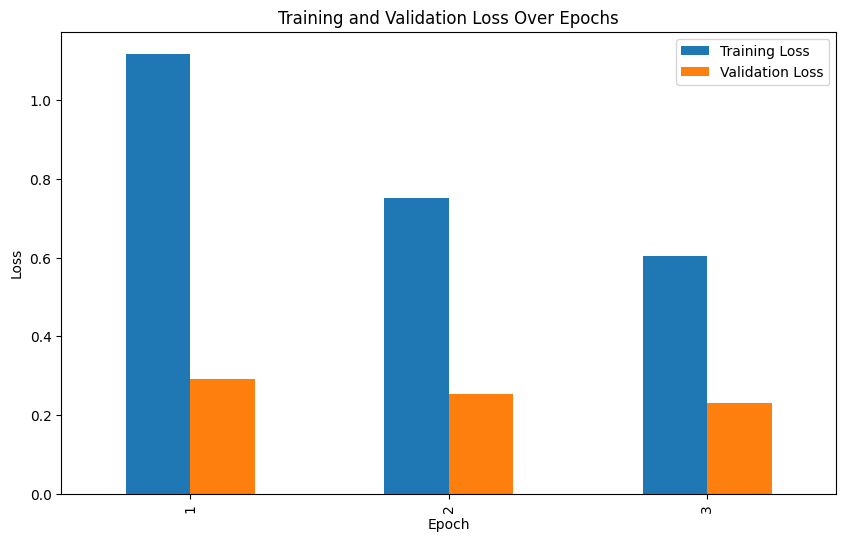

In [ ]:
# Data
scores_loss = {
    'Epoch': [1, 2, 3],
    'Training Batches (Time)': ['08:19', '08:13', '08:13'],
    'Validation Batches (Time)': ['00:36', '00:36', '00:36'],
    'Training Loss': [1.1180, 0.7529, 0.6042],
    'Validation Loss': [0.2906, 0.2531, 0.2297]
}

# Create DataFrame
results = pd.DataFrame(scores_loss)

results.plot(x='Epoch', y=['Training Loss', 'Validation Loss'], kind='bar', figsize=(10, 6))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.show()

## **Predict Answer on Testcases**

Brief explanation tasks performed in function:


- **Tokenization**: Tokenizes the `question` and `context` with padding and truncation.
- **Tensor Conversion**: Converts tokenized inputs to tensors and moves them to the device.
- **Answer Generation**: Uses the model to generate an answer.
- **Decoding**: Converts the generated tokens back to a string.
- **Optional BLEU Score**: Computes the BLEU score if a reference answer is provided.
- **Returns**: Either the predicted answer or a dictionary containing the reference answer, predicted answer, and BLEU score.


In [ ]:
# Function to predict answer based on trained T5 model on a given context and question
def predict_answer_t5(context, question, reference_ans=None):
    """
    Predicts an answer to a question given a context using a fine-tuned T5 model.

    Args:
        context (str): The text passage containing the answer.
        question (str): The question to be answered.
        reference_ans (str, optional): The actual answer for BLEU score computation.

    Returns:
        dict or str: Predicted answer, and optionally, a dictionary with the reference/actual answer, predicted answer, and BLEU score.
    """

    # Tokenize the input question and context
    inputs = sentence_tokenizer(question, context, max_length=question_length, padding="max_length", truncation=True, add_special_tokens=True)

    # Convert tokenized inputs to tensors and move to the appropriate device
    input_ids = torch.tensor(inputs["input_ids"], dtype=torch.long).to(DEVICE).unsqueeze(0)
    attention_mask = torch.tensor(inputs["attention_mask"], dtype=torch.long).to(DEVICE).unsqueeze(0)

    # Generate the answer using the model
    outcomes = llm_model.generate(input_ids=input_ids, attention_mask=attention_mask)

    # Decode the predicted answer
    answer_prediction = sentence_tokenizer.decode(outcomes.flatten(), skip_special_tokens=True)

    if reference_ans:
        # Load BLEU score metric and compute the score
        bleu = evaluate.load("google_bleu")
        bleu_score = bleu.compute(predictions=[answer_prediction],
                            references=[reference_ans])

        print("Context: \n", context)
        print("\n")
        print("Question: \n", question)
        return {
            "Actual Answer: ": reference_ans,
            "Predicted Answer: ": answer_prediction,
            "BLEU Score: ": bleu_score
        }
    else:
        return answer_prediction

**BLEU SCORE**

**Definition:** The BLEU (Bilingual Evaluation Understudy) score is a metric used to evaluate the quality of machine-generated text by comparing it to reference text. It calculates precision based on n-gram overlaps between the generated and reference answers, providing a score that ranges from 0 to 1.

**Justification:** In the context of question-answering systems, the BLEU score is valuable because it assesses how closely the model's answers align with human-provided reference answers. This helps gauge the accuracy and quality of the generated responses, ensuring the model delivers contextually relevant and precise answers.

### Testing and Predictions

In [ ]:
# Predict the outcome on different test cases

# Test Case 1
contex_1 = test_data["context"][0]
question_1 = test_data["question"][0]
reference_answer_1 = test_data["answer"][0]
predict_answer_t5(context=contex_1, question=question_1, reference_ans=reference_answer_1)

Context: 
 Dog meat is consumed in some East Asian countries, including Korea, China, and Vietnam, a practice that dates back to antiquity. It is estimated that 13–16 million dogs are killed and consumed in Asia every year. Other cultures, such as Polynesia and pre-Columbian Mexico, also consumed dog meat in their history. However, Western, South Asian, African, and Middle Eastern cultures, in general, regard consumption of dog meat as taboo. In some places, however, such as in rural areas of Poland, dog fat is believed to have medicinal properties—being good for the lungs for instance. Dog meat is also consumed in some parts of Switzerland. Proponents of eating dog meat have argued that placing a distinction between livestock and dogs is western hypocrisy, and that there is no difference with eating the meat of different animals.


Question: 
 Where do some people eat dogs?


{'Actual Answer: ': 'East Asian countries',
 'Predicted Answer: ': 'East Asian countries',
 'BLEU Score: ': {'google_bleu': 1.0}}

In [ ]:
# Test Case 2
contex_2 = test_data["context"][5]
question_2 = test_data["question"][5]
reference_answer_2 = test_data["answer"][5]
predict_answer_t5(context=contex_2, question=question_2, reference_ans=reference_answer_2)

Context: 
 Official figures (as of July 21, 2008 12:00 CST) stated that 69,197 were confirmed dead, including 68,636 in Sichuan province, and 374,176 injured, with 18,222 listed as missing. The earthquake left about 4.8 million people homeless, though the number could be as high as 11 million. Approximately 15 million people lived in the affected area. It was the deadliest earthquake to hit China since the 1976 Tangshan earthquake, which killed at least 240,000 people, and the strongest in the country since the 1950 Chayu earthquake, which registered at 8.5 on the Richter magnitude scale. It is the 21st deadliest earthquake of all time. On November 6, 2008, the central government announced that it would spend 1 trillion RMB (about US $146.5 billion) over the next three years to rebuild areas ravaged by the earthquake, as part of the Chinese economic stimulus program.


Question: 
 How many people were confirmed dead?


{'Actual Answer: ': '69,197',
 'Predicted Answer: ': '69,197',
 'BLEU Score: ': {'google_bleu': 1.0}}

In [ ]:
# Test Case 3
contex_3 = test_data["context"][55]
question_3 = test_data["question"][55]
reference_answer_3 = test_data["answer"][55]
predict_answer_t5(context=contex_3, question=question_3, reference_ans=reference_answer_3)

Context: 
 In August, the couple attended the 2011 MTV Video Music Awards, at which Beyoncé performed "Love on Top" and started the performance saying "Tonight I want you to stand up on your feet, I want you to feel the love that's growing inside of me". At the end of the performance, she dropped her microphone, unbuttoned her blazer and rubbed her stomach, confirming her pregnancy she had alluded to earlier in the evening. Her appearance helped that year's MTV Video Music Awards become the most-watched broadcast in MTV history, pulling in 12.4 million viewers; the announcement was listed in Guinness World Records for "most tweets per second recorded for a single event" on Twitter, receiving 8,868 tweets per second and "Beyonce pregnant" was the most Googled term the week of August 29, 2011.


Question: 
 Jay Z and Beyonce attended which event together in August of 2011?


{'Actual Answer: ': 'MTV Video Music Awards',
 'Predicted Answer: ': 'MTV Video Music Awards',
 'BLEU Score: ': {'google_bleu': 1.0}}

In [ ]:
# Test Case 4
contex_4 = test_data["context"][356]
question_4 = test_data["question"][356]
reference_answer_4 = test_data["answer"][356]
predict_answer_t5(context=contex_4, question=question_4, reference_ans=reference_answer_4)

Context: 
 On April 19, the BBC reported that 1,300 people had gathered outside BBC buildings in Manchester and London, protesting against what they described as Western media bias. Several days earlier, the BBC had published an article entitled "The challenges of reporting in China", responding to earlier criticism. The BBC's Paul Danahar noted that Chinese people were now "able to access the BBC News website for the first time, after years of strict censorship", and that "many were critical of our coverage". He provided readers with a reminder of censorship in China, and added: "People who criticise the media for their coverage in Tibet should acknowledge that we were and still are banned from reporting there." He also quoted critical Chinese responses, and invited readers to comment.


Question: 
 Where is BBC banned from reporting?


{'Actual Answer: ': 'Tibet',
 'Predicted Answer: ': 'Tibet',
 'BLEU Score: ': {'google_bleu': 1.0}}

In [ ]:
# Test Case 5
contex_5 = test_data["context"][890]
question_5 = test_data["question"][890]
reference_answer_5 = test_data["answer"][890]
predict_answer_t5(context=contex_5, question=question_5, reference_ans=reference_answer_5)

Context: 
 Rebirth refers to a process whereby beings go through a succession of lifetimes as one of many possible forms of sentient life, each running from conception to death. The doctrine of anattā (Sanskrit anātman) rejects the concepts of a permanent self or an unchanging, eternal soul, as it is called in Hinduism and Christianity. According to Buddhism there ultimately is no such thing as a self independent from the rest of the universe. Buddhists also refer to themselves as the believers of the anatta doctrine—Nairatmyavadin or Anattavadin. Rebirth in subsequent existences must be understood as the continuation of a dynamic, ever-changing process of pratītyasamutpāda ("dependent arising") determined by the laws of cause and effect (karma) rather than that of one being, reincarnating from one existence to the next.


Question: 
 "dependent arising" is the meaning of what word?


{'Actual Answer: ': 'pratītyasamutpāda',
 'Predicted Answer: ': 'prattyasamutpda',
 'BLEU Score: ': {'google_bleu': 0.0}}